# Mental Health in the Tech Industry  
## **Supervised Learning - Classification**
---
### Importing Libraries
(again..)

In [49]:
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
#removes the unwanted warnings for better presentation
import warnings
warnings.filterwarnings('ignore')
print("All Libraries successfully imported and ready to use 💪")

All Libraries successfully imported and ready to use 💪


### Data Loading and Description

In [50]:
df = pd.read_csv("cleaned_survey.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024 entries, 0 to 1023
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Age                        1024 non-null   int64 
 1   Gender                     1024 non-null   object
 2   Country                    1024 non-null   object
 3   self_employed              1024 non-null   object
 4   family_history             1024 non-null   object
 5   treatment                  1024 non-null   object
 6   work_interfere             1024 non-null   object
 7   no_employees               1024 non-null   object
 8   remote_work                1024 non-null   object
 9   benefits                   1024 non-null   object
 10  care_options               1024 non-null   object
 11  wellness_program           1024 non-null   object
 12  seek_help                  1024 non-null   object
 13  anonymity                  1024 non-null   object
 14  leave   

In [51]:
df.sample(10)

,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,benefits,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
215,28,Male,United States,No,Yes,No,Sometimes,100-500,No,Yes,...,Yes,Medium,No,No,Some of them,Yes,No,Maybe,Yes,Yes
694,29,Female,United States,No,Yes,Yes,Rarely,100-500,No,Yes,...,Don't know,Medium,No,No,Yes,Yes,No,Maybe,Don't know,No
321,26,Female,United States,No,Yes,Yes,Never,More than 1000,No,Yes,...,Yes,Medium,Maybe,No,No,No,No,No,Don't know,No
22,33,Male,United States,No,No,No,Sometimes,1-5,No,Don't know,...,Don't know,Medium,Maybe,Maybe,Some of them,No,No,No,Don't know,No
367,28,Male,United States,No,No,No,Never,6-25,No,Don't know,...,Don't know,Medium,No,No,Some of them,Yes,No,No,Don't know,No
595,32,Male,United States,Yes,No,Yes,Sometimes,1-5,Yes,Don't know,...,Don't know,Easy,No,No,Yes,Yes,Yes,Yes,Don't know,No
642,27,Male,United Kingdom,No,No,No,Never,26-100,No,Don't know,...,Don't know,Medium,No,No,Some of them,No,Yes,Yes,Don't know,No
855,26,Male,Australia,No,Yes,Yes,Sometimes,26-100,Yes,No,...,Yes,Medium,No,No,Yes,Yes,No,Maybe,Yes,No
1009,30,Male,Netherlands,No,No,No,Sometimes,500-1000,No,Don't know,...,Don't know,Medium,Maybe,No,Yes,Yes,Maybe,Yes,Don't know,No
316,32,Female,United States,No,No,Yes,Sometimes,26-100,No,Yes,...,Yes,Medium,Maybe,No,Some of them,Yes,No,Maybe,Yes,No


### Feature Engineering
---

These columns were chosen for the support_score because they directly measure different aspects of mental health support in the workplace:

benefits, care_options, wellness_program, seek_help, anonymity - reflect the existence of policies, programs, and cultural attitudes toward mental health.   
supervisor, coworkers - measure interpersonal support and openness from peers and managers.   
leave - indicates the ease or difficulty of taking leave for mental health reasons.

Together, these cover both organizational and interpersonal dimensions of support, providing a compact, meaningful numeric feature for the model.


In [52]:
value_map = {
    'Yes': 1.0,
    'No': 0.0,
    "Don't know": 2.0,
    'Not sure': 2.0,
    'Some of them': 0.5,
    'Difficult': 0.0,
    'Medium': 0.5,
    'Easy': 1.0
}

'''--- Columns that will be part of support score ---
These columns were chosen for the support_score because they directly measure different aspects of mental health support in the workplace:
benefits, care_options, wellness_program, seek_help, anonymity - reflect the existence of policies, programs, and cultural attitudes toward mental health.
supervisor, coworkers - measure interpersonal support and openness from peers and managers.
leave - indicates the ease or difficulty of taking leave for mental health reasons.
Together, these cover both organizational and interpersonal dimensions of support, providing a compact, meaningful numeric feature for the model.'''

support_score_cols = [
    'benefits', 'care_options', 'wellness_program',
    'seek_help', 'anonymity', 'supervisor', 'coworkers', 'leave'
]
print("On my way to create a brand new column 💥 'support_score'")

On my way to create a brand new column 💥 'support_score'


In [53]:
#Creating a custom transformer for support score column so that we can use it in the final pipeline and save it for later streamlit deployment wihtout
#any loss of feature engineering we did
from sklearn.base import BaseEstimator, TransformerMixin

class SupportScoreTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, support_score_cols, value_map):
        self.support_score_cols = support_score_cols
        self.value_map = value_map

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.support_score_cols:
            X[f"{col}_scaled"] = X[col].map(self.value_map)
        scaled_cols = [f"{col}_scaled" for col in self.support_score_cols]
        X["support_score"] = X[scaled_cols].mean(axis=1)
        X.drop(columns=self.support_score_cols+scaled_cols, inplace=True)
        return X

### Splitting our dataset

In [54]:
y = df['treatment'].map({'Yes': 1, 'No': 0}).astype(int)
X = df.drop(columns=['treatment'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (819, 22) Test shape: (205, 22)


### Dynamic preprocessor builder function
Builds a pipeline to clean, encode, and scale numeric and categorical data for modeling.

In [55]:
def build_preprocessor(X):
    num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
    cat_cols = X.select_dtypes(include=['object']).columns.tolist()

    # Remove support score columns from categorical list
    cat_cols = [col for col in cat_cols if col not in support_score_cols]

    # Remove duplicates just in case
    num_cols = list(set(num_cols))
    cat_cols = list(set(cat_cols))

    num_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    cat_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor =  ColumnTransformer([
        ('num', num_pipe, num_cols),
        ('cat', cat_pipe, cat_cols)
    ])

    return preprocessor

"One Function to run them all"   

This function is used to evaluate the different models of classification

In [56]:
def evaluate_model(name, model, X_train, X_test, y_train, y_test, results):
    preprocessor = build_preprocessor(X_train)
    pipe = Pipeline([
        ('support_score_transformer', SupportScoreTransformer(support_score_cols, value_map)),
        ('pre', preprocessor),
        ('model', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)

    print(f"=== {name} ===")
    print(f"Accuracy: {acc:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print(f"ROC-AUC: {roc:.3f}")
    if "Logistic" in name:
        print("Best HyperParameters:", lr_gs.best_params_)
    elif "Random" in name:
        print("Best HyperParameters:", rf_gs.best_params_)
    elif "XGBoost" in name:
        print("Best HyperParameters:", xgb_gs.best_params_)
    else:
        print("Best Params:", svc_gs.best_params_)
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

    results.append({'Model': name, 'Accuracy': acc, 'F1 Score': f1, 'ROC-AUC': roc})
    return pipe

## Training of different models starts!
Using **Grid Search CV** to tune the best Hyperparameters for all models

---

### Logisitic Regression

In [57]:
#Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []
preprocessor = build_preprocessor(X_train)

#Logistic Regression
lr = LogisticRegression(max_iter=2000, random_state=42)
lr_param_grid = {
    'model__C': [0.01, 0.1, 1, 10],
    'model__solver': ['liblinear', 'lbfgs'],
    'model__penalty': ['l2']
}
lr_pipe = Pipeline([('pre', preprocessor), ('model', lr)])
lr_gs = GridSearchCV(lr_pipe, lr_param_grid, scoring='roc_auc', cv=cv, n_jobs=-1)
lr_gs.fit(X_train, y_train)
print(X_train.columns.tolist())
evaluate_model("Logistic Regression", lr_gs.best_estimator_.named_steps['model'], X_train, X_test, y_train, y_test, results)

['Age', 'Gender', 'Country', 'self_employed', 'family_history', 'work_interfere', 'no_employees', 'remote_work', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'obs_consequence']
=== Logistic Regression ===
Accuracy: 0.707
F1 Score: 0.700
ROC-AUC: 0.795
Best HyperParameters: {'model__C': 0.1, 'model__penalty': 'l2', 'model__solver': 'liblinear'}

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.73      0.71       103
           1       0.71      0.69      0.70       102

    accuracy                           0.71       205
   macro avg       0.71      0.71      0.71       205
weighted avg       0.71      0.71      0.71       205


Confusion Matrix:
 [[75 28]
 [32 70]]


Pipeline(steps=[('support_score_transformer',
                 SupportScoreTransformer(support_score_cols=['benefits',
                                                             'care_options',
                                                             'wellness_program',
                                                             'seek_help',
                                                             'anonymity',
                                                             'supervisor',
                                                             'coworkers',
                                                             'leave'],
                                         value_map={'Difficult': 0.0,
                                                    "Don't know": 2.0,
                                                    'Easy': 1.0, 'Medium': 0.5,
                                                    'No': 0.0, 'Not sure': 2.0,
                                                    'Some of them': 0.5,
                                                    'Yes': 1.0})),
                ('pre',
                 ColumnTransformer(transformers=...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Country', 'family_history',
                                                   'mental_health_consequence',
                                                   'work_interfere',
                                                   'phys_health_interview',
                                                   'Gender',
                                                   'phys_health_consequence',
                                                   'mental_health_interview',
                                                   'no_employees',
                                                   'remote_work',
                                                   'mental_vs_physical',
                                                   'self_employed',
                                                   'obs_consequence'])])),
                ('model',
                 LogisticRegression(C=0.1, max_iter=2000, random_state=42,
                                    solver='liblinear'))])

### Random Forest

In [58]:
#Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf_param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2]
}
rf_pipe = Pipeline([('pre', preprocessor), ('model', rf)])
rf_gs = GridSearchCV(rf_pipe, rf_param_grid, scoring='roc_auc', cv=cv, n_jobs=-1)
rf_gs.fit(X_train, y_train)
evaluate_model("Random Forest", rf_gs.best_estimator_.named_steps['model'], X_train, X_test, y_train, y_test, results)

=== Random Forest ===
Accuracy: 0.702
F1 Score: 0.693
ROC-AUC: 0.793
Best HyperParameters: {'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 200}

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.73      0.71       103
           1       0.71      0.68      0.69       102

    accuracy                           0.70       205
   macro avg       0.70      0.70      0.70       205
weighted avg       0.70      0.70      0.70       205


Confusion Matrix:
 [[75 28]
 [33 69]]


Pipeline(steps=[('support_score_transformer',
                 SupportScoreTransformer(support_score_cols=['benefits',
                                                             'care_options',
                                                             'wellness_program',
                                                             'seek_help',
                                                             'anonymity',
                                                             'supervisor',
                                                             'coworkers',
                                                             'leave'],
                                         value_map={'Difficult': 0.0,
                                                    "Don't know": 2.0,
                                                    'Easy': 1.0, 'Medium': 0.5,
                                                    'No': 0.0, 'Not sure': 2.0,
                                                    'Some of them': 0.5,
                                                    'Yes': 1.0})),
                ('pre',
                 ColumnTransformer(transformers=...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Country', 'family_history',
                                                   'mental_health_consequence',
                                                   'work_interfere',
                                                   'phys_health_interview',
                                                   'Gender',
                                                   'phys_health_consequence',
                                                   'mental_health_interview',
                                                   'no_employees',
                                                   'remote_work',
                                                   'mental_vs_physical',
                                                   'self_employed',
                                                   'obs_consequence'])])),
                ('model',
                 RandomForestClassifier(max_depth=10, min_samples_split=5,
                                        n_estimators=200, random_state=42))])

### XGBoost

In [59]:
#XGBoost Classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.1],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0]
}
xgb_pipe = Pipeline([('pre', preprocessor), ('model', xgb)])
xgb_gs = GridSearchCV(xgb_pipe, xgb_param_grid, scoring='roc_auc', cv=cv, n_jobs=-1)
xgb_gs.fit(X_train, y_train)
evaluate_model("XGBoost", xgb_gs.best_estimator_.named_steps['model'], X_train, X_test, y_train, y_test, results)

=== XGBoost ===
Accuracy: 0.717
F1 Score: 0.701
ROC-AUC: 0.807
Best HyperParameters: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 200, 'model__subsample': 0.8}

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.77      0.73       103
           1       0.74      0.67      0.70       102

    accuracy                           0.72       205
   macro avg       0.72      0.72      0.72       205
weighted avg       0.72      0.72      0.72       205


Confusion Matrix:
 [[79 24]
 [34 68]]


Pipeline(steps=[('support_score_transformer',
                 SupportScoreTransformer(support_score_cols=['benefits',
                                                             'care_options',
                                                             'wellness_program',
                                                             'seek_help',
                                                             'anonymity',
                                                             'supervisor',
                                                             'coworkers',
                                                             'leave'],
                                         value_map={'Difficult': 0.0,
                                                    "Don't know": 2.0,
                                                    'Easy': 1.0, 'Medium': 0.5,
                                                    'No': 0.0, 'Not sure': 2.0,
                                                    'Some of them': 0.5,
                                                    'Yes': 1.0})),
                ('pre',
                 ColumnTransformer(transformers=...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, ...))])

### Support Vector Machine (SVM)

In [60]:
# Support Vector Classifier
svc = SVC(probability=True, random_state=42)
svc_params = {
    'model__C': [0.1, 1, 10],
    'model__kernel': ['linear', 'rbf'],
    'model__gamma': ['scale']
}
svc_pipe = Pipeline([('pre', preprocessor), ('model', svc)])
svc_gs = GridSearchCV(svc_pipe, svc_params, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1)
svc_gs.fit(X_train, y_train)
evaluate_model("Support Vector Classifier", svc_gs.best_estimator_.named_steps['model'], X_train, X_test, y_train, y_test, results)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
=== Support Vector Classifier ===
Accuracy: 0.717
F1 Score: 0.704
ROC-AUC: 0.803
Best Params: {'model__C': 10, 'model__gamma': 'scale', 'model__kernel': 'linear'}

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.76      0.73       103
           1       0.73      0.68      0.70       102

    accuracy                           0.72       205
   macro avg       0.72      0.72      0.72       205
weighted avg       0.72      0.72      0.72       205


Confusion Matrix:
 [[78 25]
 [33 69]]


Pipeline(steps=[('support_score_transformer',
                 SupportScoreTransformer(support_score_cols=['benefits',
                                                             'care_options',
                                                             'wellness_program',
                                                             'seek_help',
                                                             'anonymity',
                                                             'supervisor',
                                                             'coworkers',
                                                             'leave'],
                                         value_map={'Difficult': 0.0,
                                                    "Don't know": 2.0,
                                                    'Easy': 1.0, 'Medium': 0.5,
                                                    'No': 0.0, 'Not sure': 2.0,
                                                    'Some of them': 0.5,
                                                    'Yes': 1.0})),
                ('pre',
                 ColumnTransformer(transformers=...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Country', 'family_history',
                                                   'mental_health_consequence',
                                                   'work_interfere',
                                                   'phys_health_interview',
                                                   'Gender',
                                                   'phys_health_consequence',
                                                   'mental_health_interview',
                                                   'no_employees',
                                                   'remote_work',
                                                   'mental_vs_physical',
                                                   'self_employed',
                                                   'obs_consequence'])])),
                ('model',
                 SVC(C=10, kernel='linear', probability=True,
                     random_state=42))])

### Comparision Table

In [61]:
results_df = pd.DataFrame(results).round(3).sort_values(by='ROC-AUC', ascending=False).reset_index(drop=True)
display(results_df)


,Model,Accuracy,F1 Score,ROC-AUC
0,XGBoost,0.717,0.701,0.807
1,Support Vector Classifier,0.717,0.704,0.803
2,Logistic Regression,0.707,0.700,0.795
3,Random Forest,0.702,0.693,0.793


### Comparsion Graph: using ROC-AUC

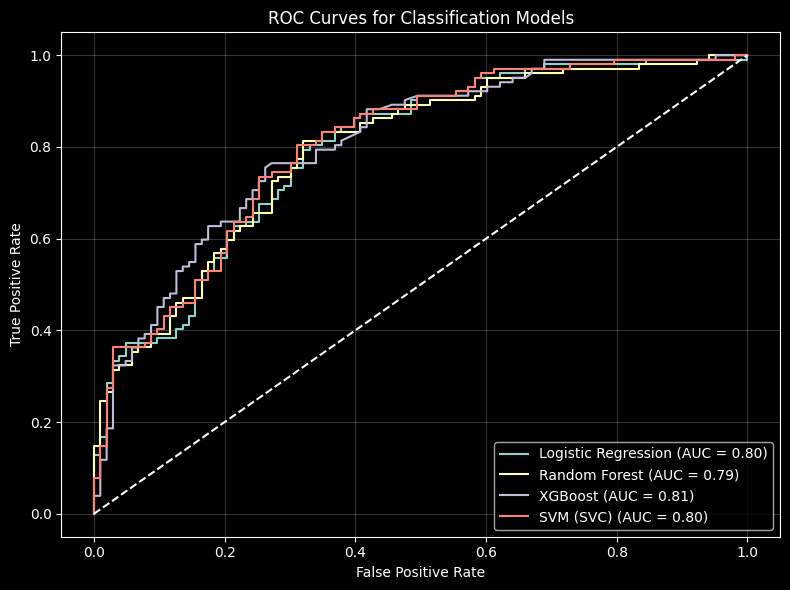

In [62]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

plt.style.use('dark_background')
plt.figure(figsize=(8,6))

models = {
    'Logistic Regression': lr_gs,
    'Random Forest': rf_gs,
    'XGBoost': xgb_gs,
    'SVM (SVC)': svc_gs
}

for name, model in models.items():
    # If model supports predict_proba
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        # Fallback for models like SVM with decision_function
        decision_scores = model.decision_function(X_test)
        y_proba = MinMaxScaler().fit_transform(decision_scores.reshape(-1, 1)).ravel()
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], color='white', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Classification Models")
plt.legend()
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()



### Saving our Best Classification Model ✨🥂

In [63]:
best_model_name = 'XGBoost'
print("Best model:", best_model_name)

final_model = xgb_gs.best_estimator_

deploy_pipeline = Pipeline([
    ('support_score_transformer', SupportScoreTransformer(support_score_cols, value_map)),
    ('preprocessor', preprocessor),
    ('model', final_model)
])

joblib.dump(deploy_pipeline, "classification_model.pkl")
print('Final model pipeline saved as classification_model.pkl')

Best model: XGBoost
Final model pipeline saved as classification_model.pkl
